In [1]:
import os
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.covariance import GraphicalLasso

import torch
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data

import hypernetx as hnx
import hypernetx.algorithms.hypergraph_modularity as hmod
import networkx as nx
from networkx.convert_matrix import from_numpy_array

import functions as f
from functions import dict_to_array, normalize_array

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/mathilde/Documents/Bachelor-Thesis-Alzheimers-HGNN/functions.py:449: DeprecationWarning: invalid escape sequence '\m'
  """The hypergraph convolutional operator from the `"Hypergraph Convolution


In [2]:
# Loading atlas, time series and threshold
_, _, atlas_labels, n_ROIs = f.gen_atlas_labels()

In [3]:
# Loading the time series
time_series_list = f.load_time_series()
time_series_df_list = f.list_of_df_of_time_series(time_series_list)
# time_series_list[0]
# time_series_df_list[0]

In [4]:
# Loading the pearson correlation matrices
corr_matrix_list = f.corr_matrix_paths()['pearson']
print(corr_matrix_list)

['patient_136_S_4517.csv', 'patient_130_S_4468.csv', 'patient_002_S_4654.csv', 'patient_002_S_4251.csv', 'patient_013_S_5171.csv', 'patient_130_S_2391.csv', 'patient_031_S_4947.csv', 'patient_100_S_5102.csv', 'patient_012_S_5121.csv', 'patient_053_S_5287.csv', 'patient_002_S_1261.csv', 'patient_018_S_4313.csv', 'patient_130_S_4641.csv', 'patient_012_S_4188.csv', 'patient_002_S_4521.csv', 'patient_130_S_4250.csv', 'patient_031_S_4005.csv', 'patient_130_S_5006.csv', 'patient_006_S_4363.csv', 'patient_012_S_4012.csv', 'patient_031_S_4149.csv', 'patient_031_S_4029.csv', 'patient_013_S_4917.csv', 'patient_129_S_4287.csv', 'patient_130_S_4730.csv', 'patient_129_S_0778.csv', 'patient_031_S_4203.csv', 'patient_013_S_4268.csv', 'patient_053_S_0919.csv', 'patient_002_S_4447.csv', 'patient_012_S_4987.csv', 'patient_018_S_4868.csv', 'patient_100_S_4556.csv', 'patient_100_S_5106.csv', 'patient_130_S_5175.csv', 'patient_130_S_4294.csv', 'patient_053_S_5296.csv', 'patient_031_S_4474.csv', 'patient_12

In [5]:
path = f'ADNI_full/corr_matrices/corr_matrix_pearson/{corr_matrix_list[0]}'
corr_matrix_patient = np.loadtxt(path, delimiter=',')
print(corr_matrix_patient)

[[ 1.          0.62126391  0.40501965 ... -0.07884583  0.07740484
  -0.36456412]
 [ 0.62126391  1.         -0.0033939  ...  0.02684759  0.0412815
  -0.1746839 ]
 [ 0.40501965 -0.0033939   1.         ... -0.17088309 -0.15494682
  -0.09877457]
 ...
 [-0.07884583  0.02684759 -0.17088309 ...  1.          0.39632277
   0.00382471]
 [ 0.07740484  0.0412815  -0.15494682 ...  0.39632277  1.
   0.35172939]
 [-0.36456412 -0.1746839  -0.09877457 ...  0.00382471  0.35172939
   1.        ]]


In [6]:
def display_hypergraph(hypergraph):
    # Displaying the hypergraph
    n_nodes = len(hypergraph.nodes)
    n_edges = len(hypergraph.edges)
    print("Hypergraph number of nodes:", n_nodes)
    print("Hypergraph number of edges:", n_edges)
    print(hypergraph.shape)

    plt.subplots(figsize=(10,10))
    hnx.draw(hypergraph, with_edge_labels=False)
    plt.show()

## Visualization of some Hypergraphs built from various method implementations

In [7]:
def remove_duplicate_hyperedges(hypergraph_dict):
    unique_hyperedges = {}
    for hyperedge, vertices in hypergraph_dict.items():
        sorted_vertices = sorted(vertices)
        sorted_vertices_tuple = tuple(sorted_vertices)
        if sorted_vertices_tuple not in unique_hyperedges.values():
            unique_hyperedges[hyperedge] = sorted_vertices_tuple
    # print("Dictionary representation of the hypergraph:")
    # print(unique_hyperedges)
    return unique_hyperedges

## Fourier Clustering Method

Hypergraph number of nodes: 116
Hypergraph number of edges: 57
(116, 57)


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

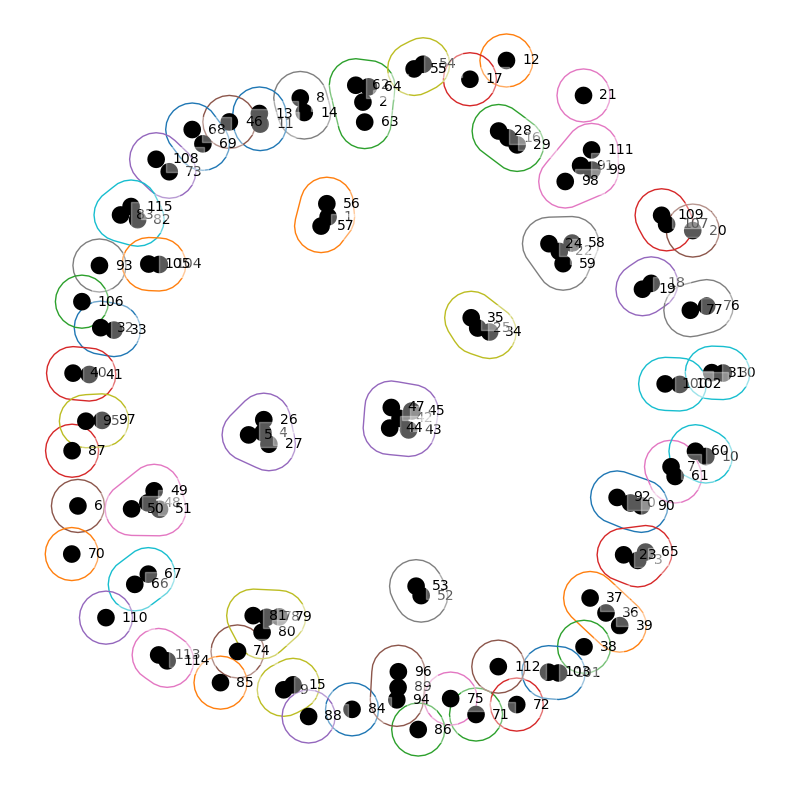

In [8]:
# Using the Fourier Clustering Method

n_patient = 17
threshold = 0.5

def adjacency_matrix_to_hypergraph_dict(adjacency_matrix):
    hypergraph_dict = {}
    for i, row in enumerate(adjacency_matrix):
        hyperedge = []
        for j, val in enumerate(row):
            if val == 1:
                hyperedge.append(j)
        hypergraph_dict[i] = hyperedge
    return hypergraph_dict

def generate_adjacency_from_cluster_indices(cluster_indices):
    n_ROIs = len(cluster_indices)
    adjacency = np.zeros((n_ROIs, n_ROIs))
    for row_idx in range(n_ROIs):
        for col_idx in range(n_ROIs):
            if cluster_indices[row_idx] == cluster_indices[col_idx]:
                adjacency[row_idx, col_idx] = 1
    return adjacency

def generate_hypergraph_from_cluster(correlation_matrix, threshold, display=False):
    # Transforming correlation matrix into dissimilarity matrix
    dissimilarity_matrix = 1 - np.abs(correlation_matrix)
    dissimilarity_matrix[np.isnan(dissimilarity_matrix)] = 0
    # Performing Fourier clustering
    linkage_matrix = linkage(squareform(dissimilarity_matrix), method='complete')
    cluster_indices = fcluster(linkage_matrix, threshold, criterion='distance')
    # Generating hypergraph from the cluster indices
    adjacency = generate_adjacency_from_cluster_indices(cluster_indices)
    hg_dict = adjacency_matrix_to_hypergraph_dict(adjacency)
    # Reducing the amount of hyperedges by removing duplicated hyperedges
    hg_dict = remove_duplicate_hyperedges(hg_dict)
    # Creating HyperNetX hypergraph
    hg = hnx.Hypergraph(hg_dict)
    if display:
        display_hypergraph(hg)
    return hg, hg_dict

# Creating HyperNetX hypergraph from clustering method
path = f'ADNI_full/corr_matrices/corr_matrix_pearson/{corr_matrix_list[n_patient]}'
corr_matrix_patient = np.loadtxt(path, delimiter=',')
hg, hg_dict = generate_hypergraph_from_cluster(corr_matrix_patient, threshold, display=True)

# for node in hg.nodes:
#     print(hg.degree(node))

## Maximal Cliques Method


Dataset: Raw_to_Graph(197):
Number of graphs: 197
Weighted: False
Threshold: 0.6
Correlation Method: pearson
Number of features: 461
Number of classes: 6

Data(edge_index=[2, 402], weight=[402], x=[116, 461], y=[1], num_nodes=116)
Number of nodes: 116
Number of edges: 402
Average node degree: 3.47
Has isolated nodes: True
Has self-loops: True
Is undirected: True
Number of cliques: 107
Maximum clique size: 7
Hypergraph number of nodes: 96
Hypergraph number of edges: 87
(96, 87)


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

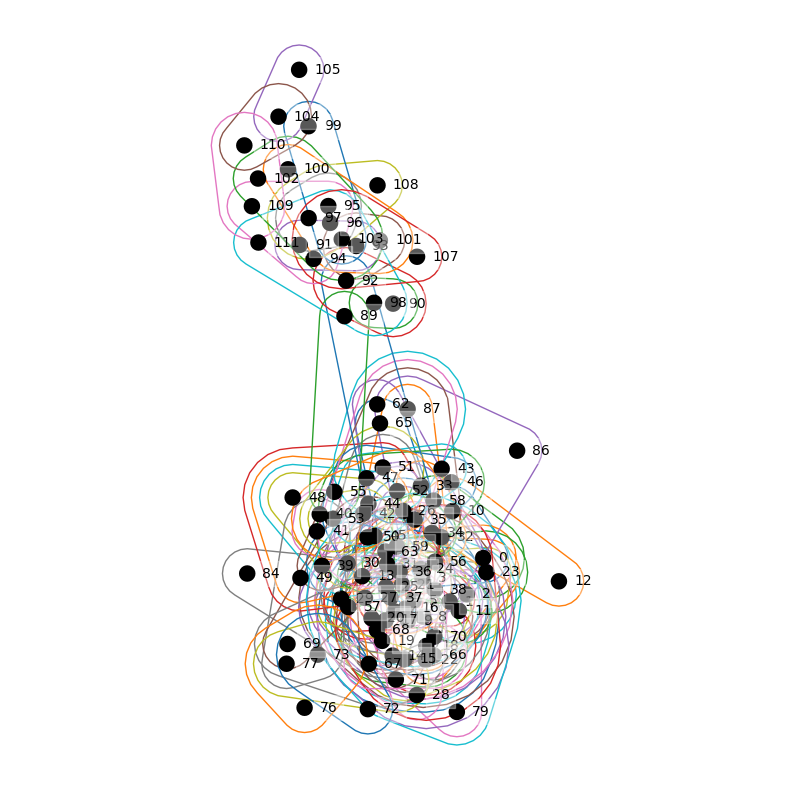

In [25]:
# Using the Maximal Cliques Method

def max_cliques(graph):
    cliques = list(nx.find_cliques(graph))
    max_clique_size = max(len(c) for c in cliques)
    summ = sum(1 for c in cliques)
    print(f"Number of cliques: {summ}")
    print(f"Maximum clique size: {max_clique_size}")
    return cliques

def graph_to_hypergraph_max_cliques(graph, display=False):
    cliques = max_cliques(graph)
    hg_dict = {i: set(clique) for i, clique in enumerate(cliques) if len(clique) > 1}
    # hg_dict = {i: set(clique) for i, clique in enumerate(cliques)}
    hg_dict = remove_duplicate_hyperedges(hg_dict)
    hg = hnx.Hypergraph(hg_dict)
    if display:
        display_hypergraph(hg)
    return hg, hg_dict

# Creating an example HyperNetX hypergraph from max cliques method
threshold = 0.6
weight = False
age = False
sex = False
matrixprofile = True
method = 'pearson'

n_patient = 25

root = f'Raw_to_graph/ADNI_T_{threshold}_M_{method}_W{weight}_A{age}_S{sex}_MP{matrixprofile}'
dataset = f.Raw_to_Graph(root=root, threshold=threshold, method=method, weight=weight, age=age, sex=sex, matrixprofile=matrixprofile)
f.dataset_features_and_stats(dataset)
graph = f.r2g_to_nx(dataset[n_patient])

hg, hg_dict = graph_to_hypergraph_max_cliques(graph, display=True)


# for node in hg.nodes:
#     print(hg.degree(node))

## Coskewness Correlation Method

In [24]:
# Computing the coskewness cube

def coskew(df):
    num = 116
    coskew_cube = [[[0 for k in range(num)] for j in range(num)] for i in range(num)]
    for i in range(num):
        v1 = df.iloc[:, i]
        meanv1 = np.mean(v1)
        std1 = np.std(v1)
        for j in range(num):
            v2 = df.iloc[:, j]
            meanv2 = np.mean(v2)
            std2 = np.std(v2)
            for k in range(num):
                v3 = df.iloc[:, k]
                meanv3 = np.mean(v3)
                std3 = np.std(v3)
                coskew_cube[i][j][k] = (np.mean((v1-meanv1)*(v2-meanv2)*(v3-meanv3)))/(std1*std2*std3)

    print(np.min(coskew_cube))
    print(np.max(coskew_cube))
    
    return coskew_cube

-0.9358056085174817
0.8186927870179522
          0         1         2         3         4         5         6    \
0    0.264269  0.160402  0.573714 -0.016659  0.147470  0.327784  0.563114   
1    0.190860  0.211386 -0.334215  0.574008 -0.535597 -0.334685  0.021171   
2    0.728310  0.593930  0.083174  0.961234 -0.744761 -0.343953  0.225210   
3    1.173054  0.813959  0.850006  0.986218 -0.296675 -0.042714  0.487224   
4    0.520118  0.189850  0.294528  0.572696  0.235907 -0.238069 -0.158185   
..        ...       ...       ...       ...       ...       ...       ...   
134 -1.887287 -0.764243 -2.184397 -0.703209 -0.268133  0.508347 -1.634119   
135 -1.408172 -0.359410 -1.143153  0.383183  0.688927  0.152477 -0.765884   
136 -0.556275 -0.673630  0.305497  0.371132  1.935064  0.062150  0.366279   
137 -0.059465 -0.803845  0.755897  0.056427  1.975473  0.260254  0.696158   
138  0.099268  0.105493  0.253143  0.189465  0.149945  0.385766  0.264674   

          7         8         9    .

In [ ]:
# Example Coskewness Cube

coskew_cube = coskew(time_series_df_list[0])
print(time_series_df_list[0])
print(time_series_df_list[0][0])
print(time_series_df_list[0][5])
print(time_series_df_list[0][115])

print(np.mean(coskew_cube))

print(len(coskew_cube))
print(len(coskew_cube[0]))
print(len(coskew_cube[0][0]))
print(coskew_cube[0][0][0])

In [32]:
# Saving the Coskewness Cubes
def save_coskew_matrices(coskew_cube, filename):
    with open(filename, 'wb') as fl:
        pkl.dump(coskew_cube, fl)
    return None

In [34]:
# Computing and saving the coskewness matrices
for i, time_series_df in enumerate(time_series_df_list):
    directory = f'ADNI_full/coskew_matrices/'
    patient_info = pd.read_csv('ADNI_full/patient_info.csv')
    os.makedirs(directory, exist_ok=True)
    idx_patient = patient_info['Subject ID'].values[i]
    filename = f'patient_{idx_patient}.pkl'
    if filename in os.listdir(directory):
        print(f"File {filename} already exists")
    else:
        filename = f'{directory}{filename}'
        coskew_cube = coskew(time_series_df)
        print('Done Processing patient nbr', i)
        save_coskew_matrices(coskew_cube, filename)

File patient_002_S_0295.pkl already exists
File patient_002_S_0413.pkl already exists
File patient_002_S_0685.pkl already exists
File patient_002_S_0729.pkl already exists
File patient_002_S_1155.pkl already exists
File patient_002_S_1261.pkl already exists
File patient_002_S_1268.pkl already exists
File patient_002_S_1280.pkl already exists
File patient_002_S_2010.pkl already exists
File patient_002_S_2043.pkl already exists
File patient_002_S_2073.pkl already exists
File patient_002_S_4171.pkl already exists
File patient_002_S_4213.pkl already exists
File patient_002_S_4219.pkl already exists
File patient_002_S_4225.pkl already exists
File patient_002_S_4229.pkl already exists
File patient_002_S_4237.pkl already exists
File patient_002_S_4251.pkl already exists
File patient_002_S_4262.pkl already exists
File patient_002_S_4264.pkl already exists
File patient_002_S_4270.pkl already exists
File patient_002_S_4447.pkl already exists
File patient_002_S_4473.pkl already exists
File patien

Hypergraph number of nodes: 8
Hypergraph number of edges: 15
(8, 15)


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

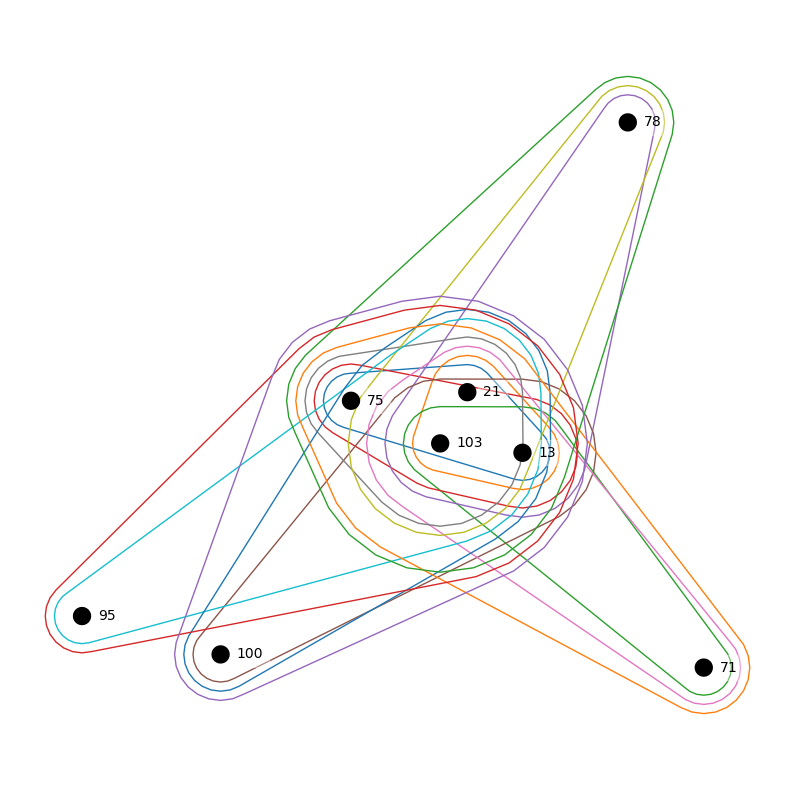

3
3
14
7
6
3
7
2


In [44]:
# Building a hypergraph from a coskewness cube
def adjacency_cube_to_hypergraph_dict(adjacency_cube):
    hg_dict = {}
    hyperedge_nbr = 0
    for i, row in enumerate(adjacency_cube):
        for j, col in enumerate(row):
            for k, val in enumerate(col):
                if val == 1:
                    if (i != j) and (i != k) and (j != k):
                        hg_dict[hyperedge_nbr] = [i, j, k]
                        hyperedge_nbr += 1
    return hg_dict

def coskewness_cube_to_hypergraph(coskewness_cube, threshold, display=False):
    adjacency_cube = np.zeros_like(coskewness_cube)
    for i in range(len(coskewness_cube)):
        for j in range(len(coskewness_cube[i])):
            for k in range(len(coskewness_cube[i][j])):
                if np.abs(coskewness_cube[i][j][k]) > threshold:
                    adjacency_cube[i][j][k] = 1
    hg_dict = adjacency_cube_to_hypergraph_dict(adjacency_cube)
    hg_dict = remove_duplicate_hyperedges(hg_dict)
    hg = hnx.Hypergraph(hg_dict)
    if display:
        display_hypergraph(hg)
    return hg, hg_dict

# Creating an example HyperNetX hypergraph from coskewness matrix
threshold = 0.4
filename = f'ADNI_full/coskew_matrices/patient_002_S_0295.pkl'
coskewness_cube = pkl.load(open(filename, 'rb'))
hg, hg_dict = coskewness_cube_to_hypergraph(coskewness_cube, threshold)
display_hypergraph(hg)

for node in hg.nodes:
    print(hg.degree(node))

## K-Nearest Neighbours Clustering Method

In [ ]:
# Using the K-Nearest Neighbours Clustering Method

from sklearn.neighbors import NearestNeighbors

n_patient = 25
# Define the number of neighbors for k-nearest neighbors
k_neighbors = 3

def generate_adjacency_from_knn(X, k_neighbors=3):
    # Finding k-nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k_neighbors, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    n_samples = X.shape[0]
    adjacency = np.zeros((n_samples, n_samples))
    # Constructing adjacency matrix based on k-nearest neighbors
    for i in range(n_samples):
        for j in indices[i]:
            adjacency[i, j] = 1
            adjacency[j, i] = 1
    return adjacency

def adjacency_matrix_to_hypergraph_dict(adjacency_matrix):
    hypergraph_dict = {}
    for i, row in enumerate(adjacency_matrix):
        hyperedge = []
        for j, val in enumerate(row):
            if val == 1:
                hyperedge.append(j)
        hypergraph_dict[i] = hyperedge
    return hypergraph_dict

def generate_hypergraph_from_knn(data_matrix, k_neighbors, display=False):
    # Generating adjacency matrix from k-nearest neighbors
    adjacency = generate_adjacency_from_knn(data_matrix, k_neighbors)
    # Generating hypergraph from the adjacency matrix
    hg_dict = adjacency_matrix_to_hypergraph_dict(adjacency)
    # Removing duplicate hyperedges (optional)
    hg_dict = remove_duplicate_hyperedges(hg_dict)
    # Creating HyperNetX hypergraph
    hg = hnx.Hypergraph(hg_dict)
    if display:
        display_hypergraph(hg)
    return hg, hg_dict

# Example usage:
# Assuming corr_matrix_patient is your data matrix (replace this with your actual data)
path = f'ADNI_full/corr_matrices/corr_matrix_pearson/{corr_matrix_list[n_patient]}'
corr_matrix_patient = np.loadtxt(path, delimiter=',')
hg, hg_dict = generate_hypergraph_from_knn(corr_matrix_patient, k_neighbors, display=True)

# Saving the Hypergraphs for all methods

In [21]:
# Defining a function to save hypergraphs
def save_hypergraph(hg_dict, directory, method, threshold, id):
    dir = f'{directory}/{method}/thresh_{threshold}'
    if not os.path.exists(dir):
        os.makedirs(dir)
    with open(f'{dir}/{id}_{method}_{threshold}.pkl', 'wb') as f:
        pkl.dump(hg_dict, f)
    return

In [47]:
time_series_folder = 'ADNI_full/time_series'
threshold = 0.6

for i, file_name in enumerate(os.listdir(time_series_folder)):
    patient_id = file_name[3:13]
    print(f'Processing patient {patient_id}')
    # for method in ['fourier_cluster', 'maximal_clique', 'coskewness']:
    # for method in ['maximal_clique', 'fourier_cluster']:
    for method in ['knn']:
        if method == 'fourier_cluster':
            path = f'ADNI_full/corr_matrices/corr_matrix_pearson/{corr_matrix_list[i]}'
            corr_matrix_patient = np.loadtxt(path, delimiter=',')
            _, hg_dict = generate_hypergraph_from_cluster(corr_matrix_patient, threshold=threshold)
        elif method == 'maximal_clique':
            method_corr = 'pearson'
            root = f'Raw_to_graph/ADNI_T_{threshold}_M_{method_corr}_WFalse_AFalse_SFalse_MPTrue'
            dataset = f.Raw_to_Graph(root=root, threshold=threshold, method=method_corr, weight=False, age=False, sex=False, matrixprofile=True)
            graph = f.r2g_to_nx(dataset[0])
            _, hg_dict = graph_to_hypergraph_max_cliques(graph)
        elif method == 'coskewness':
            filename = f'ADNI_full/coskew_matrices/patient_{patient_id}.pkl'
            coskew_cube = pkl.load(open(filename, 'rb'))
            _, hg_dict = coskewness_cube_to_hypergraph(coskew_cube, threshold=threshold)
        elif method == 'knn':
            k_neighbors = 3
            path = f'ADNI_full/corr_matrices/corr_matrix_pearson/{corr_matrix_list[i]}'
            corr_matrix_patient = np.loadtxt(path, delimiter=',')
            _, hg_dict = generate_hypergraph_from_knn(corr_matrix_patient, k_neighbors)
            threshold = f'{k_neighbors}neighbors'
        save_hypergraph(hg_dict, 'Hypergraphs', method, threshold, patient_id)
        print(f'Patient {patient_id} processed and saved for the {method} method with threshold {threshold}')

Processing patient 130_S_4883


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_4883 processed and saved for the coskewness method with threshold 0.6
Processing patient 100_S_5091


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 100_S_5091 processed and saved for the coskewness method with threshold 0.6
Processing patient 019_S_4549


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 019_S_4549 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_4473


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_4473 processed and saved for the coskewness method with threshold 0.6
Processing patient 006_S_4546


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 006_S_4546 processed and saved for the coskewness method with threshold 0.6
Processing patient 018_S_4257


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 018_S_4257 processed and saved for the coskewness method with threshold 0.6
Processing patient 013_S_2389


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 013_S_2389 processed and saved for the coskewness method with threshold 0.6
Processing patient 019_S_4367


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 019_S_4367 processed and saved for the coskewness method with threshold 0.6
Processing patient 018_S_4733


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 018_S_4733 processed and saved for the coskewness method with threshold 0.6
Processing patient 018_S_2155


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 018_S_2155 processed and saved for the coskewness method with threshold 0.6
Processing patient 031_S_4590


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 031_S_4590 processed and saved for the coskewness method with threshold 0.6
Processing patient 136_S_4269


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 136_S_4269 processed and saved for the coskewness method with threshold 0.6
Processing patient 019_S_4548


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 019_S_4548 processed and saved for the coskewness method with threshold 0.6
Processing patient 031_S_4194


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 031_S_4194 processed and saved for the coskewness method with threshold 0.6
Processing patient 010_S_4442


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 010_S_4442 processed and saved for the coskewness method with threshold 0.6
Processing patient 131_S_5138


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 131_S_5138 processed and saved for the coskewness method with threshold 0.6
Processing patient 006_S_4357


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 006_S_4357 processed and saved for the coskewness method with threshold 0.6
Processing patient 012_S_4026


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 012_S_4026 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_5142


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_5142 processed and saved for the coskewness method with threshold 0.6
Processing patient 018_S_2180


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 018_S_2180 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_4262


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_4262 processed and saved for the coskewness method with threshold 0.6
Processing patient 136_S_0186


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 136_S_0186 processed and saved for the coskewness method with threshold 0.6
Processing patient 031_S_4021


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 031_S_4021 processed and saved for the coskewness method with threshold 0.6
Processing patient 006_S_4960


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 006_S_4960 processed and saved for the coskewness method with threshold 0.6
Processing patient 053_S_4578


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 053_S_4578 processed and saved for the coskewness method with threshold 0.6
Processing patient 129_S_4073


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 129_S_4073 processed and saved for the coskewness method with threshold 0.6
Processing patient 018_S_4889


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 018_S_4889 processed and saved for the coskewness method with threshold 0.6
Processing patient 006_S_4150


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 006_S_4150 processed and saved for the coskewness method with threshold 0.6
Processing patient 053_S_5070


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 053_S_5070 processed and saved for the coskewness method with threshold 0.6
Processing patient 018_S_4696


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 018_S_4696 processed and saved for the coskewness method with threshold 0.6
Processing patient 053_S_5272


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 053_S_5272 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_1280


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_1280 processed and saved for the coskewness method with threshold 0.6
Processing patient 006_S_4346


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 006_S_4346 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_2010


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_2010 processed and saved for the coskewness method with threshold 0.6
Processing patient 031_S_4024


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 031_S_4024 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_2403


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_2403 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_5178


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_5178 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_5018


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_5018 processed and saved for the coskewness method with threshold 0.6
Processing patient 100_S_5280


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 100_S_5280 processed and saved for the coskewness method with threshold 0.6
Processing patient 100_S_5096


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 100_S_5096 processed and saved for the coskewness method with threshold 0.6
Processing patient 006_S_4192


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 006_S_4192 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_4660


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_4660 processed and saved for the coskewness method with threshold 0.6
Processing patient 006_S_4153


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:335: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1]) ##Nodes(self.E) ##


Patient 006_S_4153 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_5230


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_5230 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_1268


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_1268 processed and saved for the coskewness method with threshold 0.6
Processing patient 006_S_0731


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 006_S_0731 processed and saved for the coskewness method with threshold 0.6
Processing patient 019_S_4835


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 019_S_4835 processed and saved for the coskewness method with threshold 0.6
Processing patient 019_S_5242


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:335: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1]) ##Nodes(self.E) ##


Patient 019_S_5242 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_4270


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_4270 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_4264


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_4264 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_2373


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_2373 processed and saved for the coskewness method with threshold 0.6
Processing patient 053_S_4557


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 053_S_4557 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_4925


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_4925 processed and saved for the coskewness method with threshold 0.6
Processing patient 031_S_4032


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 031_S_4032 processed and saved for the coskewness method with threshold 0.6
Processing patient 031_S_4218


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 031_S_4218 processed and saved for the coskewness method with threshold 0.6
Processing patient 053_S_4813


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 053_S_4813 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_0413


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_0413 processed and saved for the coskewness method with threshold 0.6
Processing patient 012_S_4545


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 012_S_4545 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_5256


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_5256 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_4799


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_4799 processed and saved for the coskewness method with threshold 0.6
Processing patient 019_S_4477


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 019_S_4477 processed and saved for the coskewness method with threshold 0.6
Processing patient 013_S_5137


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 013_S_5137 processed and saved for the coskewness method with threshold 0.6
Processing patient 053_S_2357


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 053_S_2357 processed and saved for the coskewness method with threshold 0.6
Processing patient 053_S_5202


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 053_S_5202 processed and saved for the coskewness method with threshold 0.6
Processing patient 129_S_4371


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 129_S_4371 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_4605


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_4605 processed and saved for the coskewness method with threshold 0.6
Processing patient 010_S_4345


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 010_S_4345 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_4405


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_4405 processed and saved for the coskewness method with threshold 0.6
Processing patient 041_S_5026


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 041_S_5026 processed and saved for the coskewness method with threshold 0.6
Processing patient 006_S_4485


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 006_S_4485 processed and saved for the coskewness method with threshold 0.6
Processing patient 012_S_5213


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 012_S_5213 processed and saved for the coskewness method with threshold 0.6
Processing patient 053_S_2396


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 053_S_2396 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_4229


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_4229 processed and saved for the coskewness method with threshold 0.6
Processing patient 012_S_4643


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 012_S_4643 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_0729


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_0729 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_4997


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_4997 processed and saved for the coskewness method with threshold 0.6
Processing patient 031_S_4042


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 031_S_4042 processed and saved for the coskewness method with threshold 0.6
Processing patient 013_S_1186


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 013_S_1186 processed and saved for the coskewness method with threshold 0.6
Processing patient 019_S_5019


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 019_S_5019 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_4982


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_4982 processed and saved for the coskewness method with threshold 0.6
Processing patient 136_S_4433


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 136_S_4433 processed and saved for the coskewness method with threshold 0.6
Processing patient 031_S_2022


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 031_S_2022 processed and saved for the coskewness method with threshold 0.6
Processing patient 018_S_5262


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 018_S_5262 processed and saved for the coskewness method with threshold 0.6
Processing patient 006_S_4679


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 006_S_4679 processed and saved for the coskewness method with threshold 0.6
Processing patient 131_S_5148


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 131_S_5148 processed and saved for the coskewness method with threshold 0.6
Processing patient 013_S_4616


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 013_S_4616 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_2073


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_2073 processed and saved for the coskewness method with threshold 0.6
Processing patient 012_S_4849


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 012_S_4849 processed and saved for the coskewness method with threshold 0.6
Processing patient 018_S_4597


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 018_S_4597 processed and saved for the coskewness method with threshold 0.6
Processing patient 031_S_4721


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 031_S_4721 processed and saved for the coskewness method with threshold 0.6
Processing patient 100_S_4512


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 100_S_4512 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_4415


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_4415 processed and saved for the coskewness method with threshold 0.6
Processing patient 006_S_4867


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 006_S_4867 processed and saved for the coskewness method with threshold 0.6
Processing patient 031_S_2233


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 031_S_2233 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_4171


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_4171 processed and saved for the coskewness method with threshold 0.6
Processing patient 012_S_4094


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 012_S_4094 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_4417


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_4417 processed and saved for the coskewness method with threshold 0.6
Processing patient 136_S_4408


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 136_S_4408 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_4213


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_4213 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_1155


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_1155 processed and saved for the coskewness method with threshold 0.6
Processing patient 013_S_4985


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 013_S_4985 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_4984


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_4984 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_4990


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_4990 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_4589


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_4589 processed and saved for the coskewness method with threshold 0.6
Processing patient 018_S_2133


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 018_S_2133 processed and saved for the coskewness method with threshold 0.6
Processing patient 031_S_4496


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 031_S_4496 processed and saved for the coskewness method with threshold 0.6
Processing patient 031_S_2018


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 031_S_2018 processed and saved for the coskewness method with threshold 0.6
Processing patient 018_S_4349


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 018_S_4349 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_4237


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_4237 processed and saved for the coskewness method with threshold 0.6
Processing patient 019_S_5012


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 019_S_5012 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_4746


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_4746 processed and saved for the coskewness method with threshold 0.6
Processing patient 006_S_4713


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 006_S_4713 processed and saved for the coskewness method with threshold 0.6
Processing patient 129_S_4422


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 129_S_4422 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_4817


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_4817 processed and saved for the coskewness method with threshold 0.6
Processing patient 018_S_5240


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 018_S_5240 processed and saved for the coskewness method with threshold 0.6
Processing patient 100_S_4469


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 100_S_4469 processed and saved for the coskewness method with threshold 0.6
Processing patient 019_S_4293


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 019_S_4293 processed and saved for the coskewness method with threshold 0.6
Processing patient 019_S_4285


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 019_S_4285 processed and saved for the coskewness method with threshold 0.6
Processing patient 018_S_4809


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 018_S_4809 processed and saved for the coskewness method with threshold 0.6
Processing patient 019_S_4252


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 019_S_4252 processed and saved for the coskewness method with threshold 0.6
Processing patient 013_S_4395


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 013_S_4395 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_2043


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_2043 processed and saved for the coskewness method with threshold 0.6
Processing patient 136_S_0107


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 136_S_0107 processed and saved for the coskewness method with threshold 0.6
Processing patient 013_S_4791


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 013_S_4791 processed and saved for the coskewness method with threshold 0.6
Processing patient 136_S_4189


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 136_S_4189 processed and saved for the coskewness method with threshold 0.6
Processing patient 013_S_4579


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 013_S_4579 processed and saved for the coskewness method with threshold 0.6
Processing patient 100_S_2351


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 100_S_2351 processed and saved for the coskewness method with threshold 0.6
Processing patient 019_S_4680


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 019_S_4680 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_4343


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_4343 processed and saved for the coskewness method with threshold 0.6
Processing patient 053_S_5208


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 053_S_5208 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_5059


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_5059 processed and saved for the coskewness method with threshold 0.6
Processing patient 031_S_4476


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 031_S_4476 processed and saved for the coskewness method with threshold 0.6
Processing patient 013_S_5071


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 013_S_5071 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_4219


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_4219 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_4225


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_4225 processed and saved for the coskewness method with threshold 0.6
Processing patient 018_S_2138


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 018_S_2138 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_4971


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_4971 processed and saved for the coskewness method with threshold 0.6
Processing patient 012_S_4128


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 012_S_4128 processed and saved for the coskewness method with threshold 0.6
Processing patient 006_S_5153


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 006_S_5153 processed and saved for the coskewness method with threshold 0.6
Processing patient 018_S_4400


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 018_S_4400 processed and saved for the coskewness method with threshold 0.6
Processing patient 053_S_4661


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 053_S_4661 processed and saved for the coskewness method with threshold 0.6
Processing patient 018_S_4399


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 018_S_4399 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_4352


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_4352 processed and saved for the coskewness method with threshold 0.6
Processing patient 136_S_4993


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 136_S_4993 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_5258


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_5258 processed and saved for the coskewness method with threshold 0.6
Processing patient 012_S_5195


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 012_S_5195 processed and saved for the coskewness method with threshold 0.6
Processing patient 018_S_5250


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 018_S_5250 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_0685


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_0685 processed and saved for the coskewness method with threshold 0.6
Processing patient 006_S_4449


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 006_S_4449 processed and saved for the coskewness method with threshold 0.6
Processing patient 006_S_4515


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 006_S_4515 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_4542


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_4542 processed and saved for the coskewness method with threshold 0.6
Processing patient 013_S_4595


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 013_S_4595 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_0295


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_0295 processed and saved for the coskewness method with threshold 0.6
Processing patient 129_S_4220


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 129_S_4220 processed and saved for the coskewness method with threshold 0.6
Processing patient 013_S_2324


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 013_S_2324 processed and saved for the coskewness method with threshold 0.6
Processing patient 013_S_4580


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 013_S_4580 processed and saved for the coskewness method with threshold 0.6
Processing patient 031_S_4474


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 031_S_4474 processed and saved for the coskewness method with threshold 0.6
Processing patient 129_S_4369


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 129_S_4369 processed and saved for the coskewness method with threshold 0.6
Processing patient 012_S_5157


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 012_S_5157 processed and saved for the coskewness method with threshold 0.6
Processing patient 129_S_4396


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 129_S_4396 processed and saved for the coskewness method with threshold 0.6
Processing patient 053_S_5296


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 053_S_5296 processed and saved for the coskewness method with threshold 0.6
Processing patient 100_S_5106


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 100_S_5106 processed and saved for the coskewness method with threshold 0.6
Processing patient 100_S_4556


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 100_S_4556 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_4294


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_4294 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_5175


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_5175 processed and saved for the coskewness method with threshold 0.6
Processing patient 012_S_4987


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 012_S_4987 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_4447


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_4447 processed and saved for the coskewness method with threshold 0.6
Processing patient 018_S_4868


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 018_S_4868 processed and saved for the coskewness method with threshold 0.6
Processing patient 053_S_0919


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 053_S_0919 processed and saved for the coskewness method with threshold 0.6
Processing patient 129_S_0778


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 129_S_0778 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_4730


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_4730 processed and saved for the coskewness method with threshold 0.6
Processing patient 013_S_4917


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 013_S_4917 processed and saved for the coskewness method with threshold 0.6
Processing patient 129_S_4287


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 129_S_4287 processed and saved for the coskewness method with threshold 0.6
Processing patient 031_S_4029


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 031_S_4029 processed and saved for the coskewness method with threshold 0.6
Processing patient 013_S_4268


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 013_S_4268 processed and saved for the coskewness method with threshold 0.6
Processing patient 031_S_4203


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 031_S_4203 processed and saved for the coskewness method with threshold 0.6
Processing patient 012_S_4012


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 012_S_4012 processed and saved for the coskewness method with threshold 0.6
Processing patient 006_S_4363


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 006_S_4363 processed and saved for the coskewness method with threshold 0.6
Processing patient 031_S_4149


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 031_S_4149 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_5006


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_5006 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_4250


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_4250 processed and saved for the coskewness method with threshold 0.6
Processing patient 031_S_4005


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 031_S_4005 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_4521


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_4521 processed and saved for the coskewness method with threshold 0.6
Processing patient 012_S_4188


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 012_S_4188 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_4641


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_4641 processed and saved for the coskewness method with threshold 0.6
Processing patient 012_S_5121


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 012_S_5121 processed and saved for the coskewness method with threshold 0.6
Processing patient 053_S_5287


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 053_S_5287 processed and saved for the coskewness method with threshold 0.6
Processing patient 018_S_4313


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 018_S_4313 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_1261


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_1261 processed and saved for the coskewness method with threshold 0.6
Processing patient 013_S_5171


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 013_S_5171 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_4251


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 002_S_4251 processed and saved for the coskewness method with threshold 0.6
Processing patient 100_S_5102


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 100_S_5102 processed and saved for the coskewness method with threshold 0.6
Processing patient 031_S_4947


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 031_S_4947 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_2391


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_2391 processed and saved for the coskewness method with threshold 0.6
Processing patient 130_S_4468


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 130_S_4468 processed and saved for the coskewness method with threshold 0.6
Processing patient 136_S_4517


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 136_S_4517 processed and saved for the coskewness method with threshold 0.6
Processing patient 002_S_4654
Patient 002_S_4654 processed and saved for the coskewness method with threshold 0.6


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

# Building the Raw_to_Hypergraph class

In [48]:
# Defining a class to preprocess raw data into a format suitable for training Graph Neural Networks (GNNs).
## With the possibility of assigning weight to edges, adding the age feature, sex feature, and matrixe profiling.

class Raw_to_Hypergraph(InMemoryDataset):
    def __init__(self, root, hg_data_path, method, weight, threshold, age=False, sex=False, transform=None, pre_transform=None):
        self.method = method
        self.weight = weight
        self.threshold = threshold
        self.age = age
        self.sex = sex
        self.hg_data_path = hg_data_path
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return ['data.pt']

    # This function is used to process the raw data into a format suitable for GNNs, by constructing graphs out of the connectivity matrices.
    def process(self):
        # Loading the prebuilt hypergraphs and the correlation matrices
        hg_dict_list = f.load_hg_dict(self.hg_data_path)
        full_corr_path_lists = f.corr_matrix_paths()
        corr_matrix_list = full_corr_path_lists['pearson']

        # Generating the diagnostic file from the diagnostic_label.csv file
        diagnostic_label = np.loadtxt('ADNI_full/diagnostic_label.csv', dtype=str, delimiter=',')
        # Combining the 'EMCI', 'LMCI' and 'MCI' diagnostics into a single 'MCI' label for simplicity, then one-hot encoding the diagnostics
        diagnostic_label = f.combine_diag_labels(diagnostic_label)

        graphs=[]
        for patient_idx, patient_hg in enumerate(hg_dict_list):
            # Create a NetworkX graph from the hypergraph matrix
            hypergraph = hnx.Hypergraph(patient_hg)

            # Adding the matrix profiling features to the feature array
            patient_matrix = corr_matrix_list[patient_idx]
            path = f'ADNI_full/matrix_profiles/matrix_profile_pearson/{patient_matrix}'
            if patient_matrix.endswith('.DS_Store'):
                continue  # Skip hidden system files like .DS_Store
            with open(path, "rb") as fl:
                patient_dict = pkl.load(fl)
            # combine dimensions
            features = np.array(patient_dict['mp']).reshape(len(patient_dict['mp']),-1)
            features = features.astype(np.float32)

            # Loading the atlas, atlas labels and nbr_ROIS
            _, _, _, nbr_ROIs = f.gen_atlas_labels()    
            if self.age:
                # Loading the age feature of patients to use as a node feature
                ages = np.loadtxt('ADNI_full/age.csv', delimiter=',')
                min_age = np.min(ages)
                max_age = np.max(ages)
                # Extracting the age feature of the patient
                patient_age = ages[patient_idx]
                age_norm = (patient_age - min_age) / (max_age - min_age)
                # Making the age array the same size as the other arrays
                age_array = np.full((nbr_ROIs,), age_norm)
                features = np.concatenate((features, age_array), axis=-1)
            if self.sex:
                # Prepocessing the sex feature of patients to use as a node feature. Here, 0 represents male patients and 1 represents female patients
                sex = np.loadtxt('ADNI_full/sex.csv', dtype=str, delimiter=',')
                for patient in range(len(sex)):
                    if sex[patient] == 'M':
                        sex[patient] = 0
                    else:
                        sex[patient] = 1
                # Extracting the sex feature of the patient
                patient_sex = int(sex[patient_idx])
                # Making the sex array the same size as the other arrays
                sex_array = np.full((nbr_ROIs,), patient_sex)
                features = np.concatenate((features, sex_array), axis=-1)

            # Concatenate the degree, participation coefficient, betweenness centrality, local efficiency, and ratio of local to global efficiency arrays to form a single feature vector
            x = torch.tensor(features, dtype=torch.float)

            # Create a Pytorch Geometric Data object
            edge_index0 = []
            edge_index1 = []
            i = 0
            for hyperedge, nodes in hypergraph.incidence_dict.items():
                edge_index0 = np.concatenate((edge_index0, nodes), axis=0)
                for j in range(len(nodes)):
                    edge_index1.append(i)
                i += 1
            edge_index = np.stack([[int(x) for x in edge_index0], edge_index1], axis=0)
            y = torch.tensor(float(diagnostic_label[patient_idx]))
            hg_data = Data(x=x, edge_index=torch.tensor(edge_index, dtype=torch.long), y=y)
            graphs.append(hg_data)

        data, slices = self.collate(graphs)
        torch.save((data, slices), self.processed_paths[0])

In [50]:
# Testing the class Raw_to_Hypergraph with one example and saving it
threshold = 0.4
k_neighbors = 3
age = False
sex = False
method = 'knn'
if method == 'knn':
    threshold = f'{k_neighbors}neighbors'
weight = False

hg_data_path = f'Hypergraphs/{method}/thresh_{threshold}'

root = f'Raw_to_hypergraph/ADNI_T_{threshold}_M_{method}_W{weight}_A{age}_S{sex}_MPTrue'
dataset = Raw_to_Hypergraph(root=root, hg_data_path=hg_data_path, method=method, weight=weight, threshold=threshold, age=age, sex=sex)

In [51]:
# Testing the class Raw_to_Graph with different thresholds, weights and methods and saving it
thresholds = [0.4, 0.5, 0.6]
age = False
sex = False
# methods = ['fourier_cluster', 'maximal_clique', 'coskewness']
methods = ['knn']
if method == 'knn':
    k_neighbors = 3
    thresholds = [f'{k_neighbors}neighbors']
weight = False

for method in methods:
    for threshold in thresholds:
        hg_data_path = f'Hypergraphs/{method}/thresh_{threshold}'
        root = f'Raw_to_hypergraph/ADNI_T_{threshold}_M_{method}_W{weight}_A{age}_S{sex}_MPTrue'
        dataset = Raw_to_Hypergraph(root=root, hg_data_path=hg_data_path, method=method, weight=weight, threshold=threshold, age=age, sex=sex)

Processing...
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = 